## Iris data set에 SVM 적용하기

In [1]:
# 필요한 모듈 import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import warnings

# ignoring Future Warning to clean up notebook
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
# 사용할 함수 정의
sns.set_style('whitegrid')

# to print summary of cross validation score
def score_summary(scores):
  print('cv_scores: ', scores)
  print('mean: ', np.mean(scores))
  print('std. deviaion: ', np.std(scores))

# to save visualizations as png images
def save_figure(fig_id):
  path = os.path.join('iris_images_' + fig_id + '.png')
  plt.savefig(path, dpi=300, format='png')

In [4]:
# sklearn의 iris 데이터셋을 불러와서 데이터프레임화
iris = load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# LabelEncoder로 품종 이름을 label로 추가
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(iris.target_names)

df['Species'] = le.inverse_transform(iris.target)
df['Species'].value_counts()

Species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

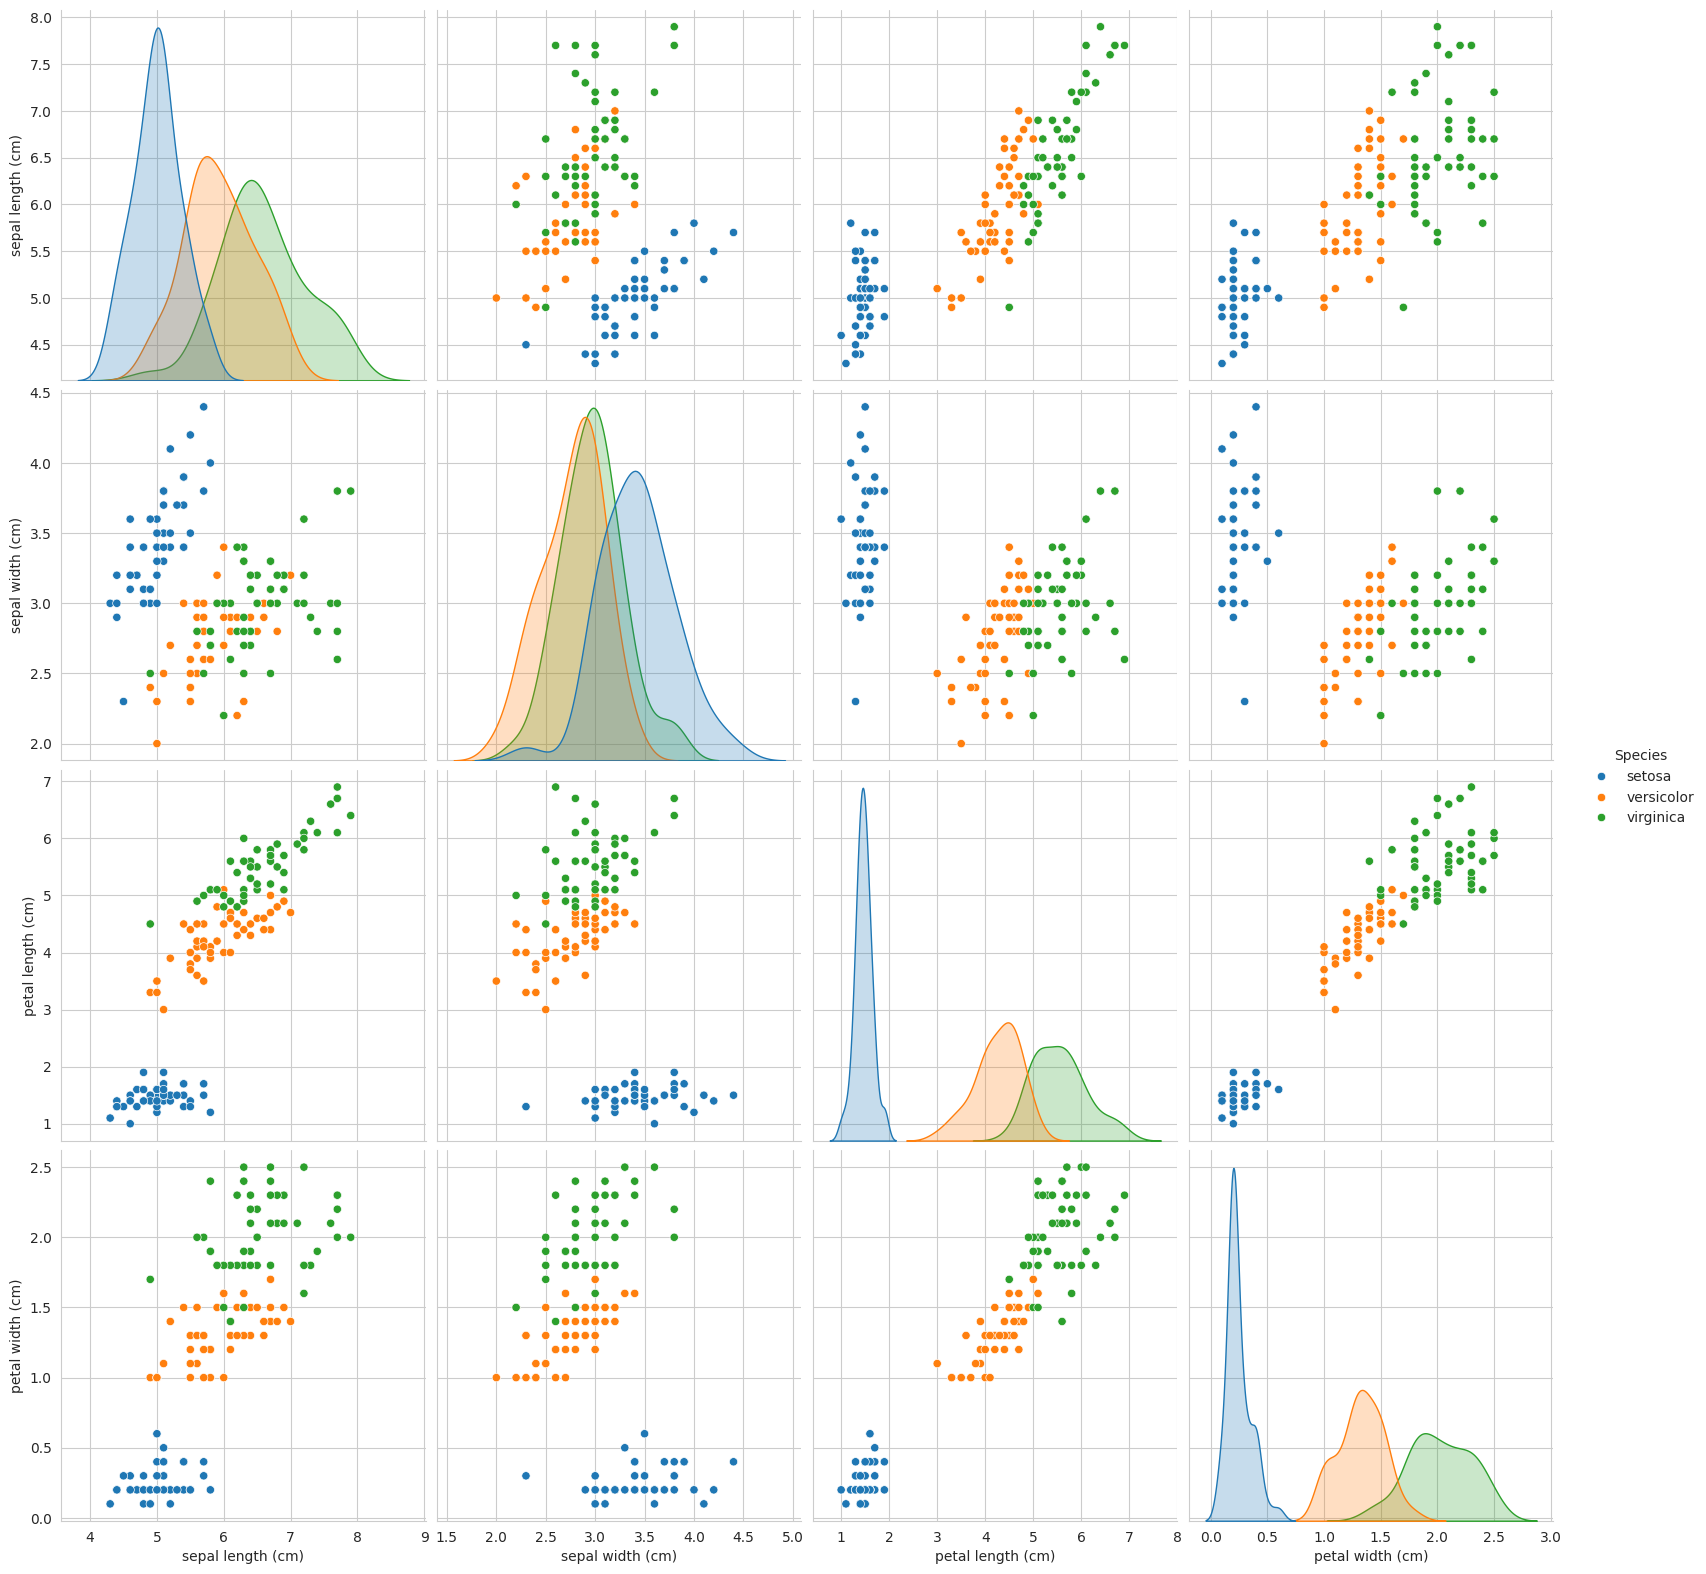

In [6]:
# 먼저 선언한 save_figure() 함수로 그림 파일로 바로 저장 가능
sns.pairplot(df, height=4, hue='Species')
save_figure('1')

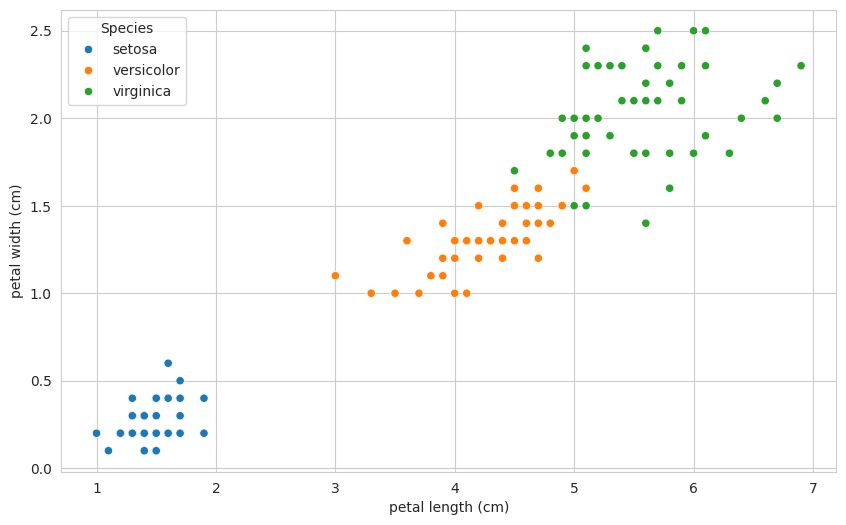

In [7]:
# petal length와 petal width의 산점도 확인
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='petal length (cm)', y='petal width (cm)', hue='Species')
save_figure('2')

In [8]:
# feature와 label 데이터 추출한 다음 데이터 분리
X = iris.data[:, 2:]
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# SVM을 적용하고 교차 검증을 통해 성능 확인
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svc_clf = SVC(gamma='auto')
svc_clf.fit(X_train, y_train)
svc_clf_scores = cross_val_score(svc_clf, X_train, y_train, cv=5)
score_summary(svc_clf_scores)

cv_scores:  [0.95833333 0.95833333 0.95833333 0.95833333 1.        ]
mean:  0.9666666666666668
std. deviaion:  0.016666666666666653


In [10]:
# 결정 경계를 출력해주는 함수 정의
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_regions(X, y, classifier, resolution=0.02):
  # 마커와 컬러맵을 설정
  markers = ('s', 'p', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # 결정 경계 그림
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  for idx, c1 in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c1, 0],
                y = X[y == c1, 1],
                alpha = 0.8,
                c = colors[idx],
                marker = markers[idx],
                label = c1,
                edgecolor = 'black')

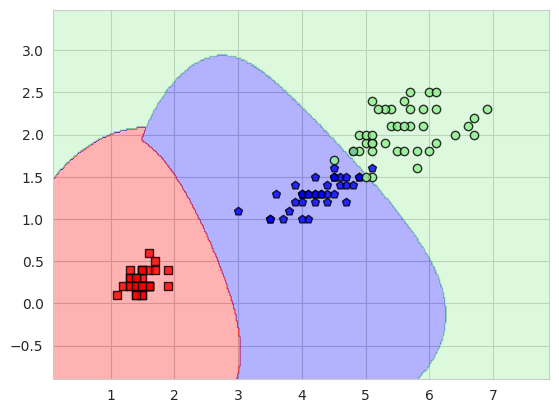

In [11]:
# 훈련용 데이터에 대한 결정 경계 확인
plot_decision_regions(X=X_train, y=y_train, classifier=svc_clf)
save_figure('3')

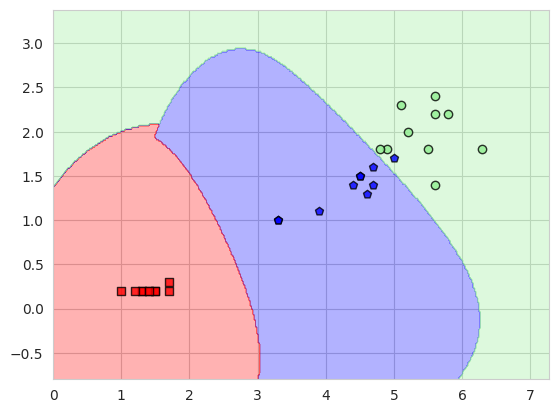

In [12]:
# 테스트 데이터에 대한 결정 경계 확인
plot_decision_regions(X=X_test, y=y_test, classifier=svc_clf)
save_figure('4')

In [13]:
# GridSearchCV()를 이용해 하이퍼패러미터 확인
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C' : [8, 9, 10, 11, 12, 15],
    'gamma' : [.01, .02, .05, .001]
}

grid = GridSearchCV(svc_clf, param_grid, cv=30)
grid.fit(X_train, y_train)

GridSearchCV(cv=30, estimator=SVC(gamma='auto'),
             param_grid={'C': [8, 9, 10, 11, 12, 15],
                         'gamma': [0.01, 0.02, 0.05, 0.001]})

In [14]:
# GridSearch 결과 확인
scores_df = pd.DataFrame(grid.cv_results_)
scores_df[['rank_test_score', 'params', 'mean_test_score']]

,rank_test_score,params,mean_test_score
0,1,"{'C': 8, 'gamma': 0.01}",0.966667
1,19,"{'C': 8, 'gamma': 0.02}",0.950000
2,4,"{'C': 8, 'gamma': 0.05}",0.958333
3,1,"{'C': 8, 'gamma': 0.001}",0.966667
4,4,"{'C': 9, 'gamma': 0.01}",0.958333
5,19,"{'C': 9, 'gamma': 0.02}",0.950000
6,4,"{'C': 9, 'gamma': 0.05}",0.958333
7,19,"{'C': 9, 'gamma': 0.001}",0.950000
8,1,"{'C': 10, 'gamma': 0.01}",0.966667
9,19,"{'C': 10, 'gamma': 0.02}",0.950000


In [15]:
# 하이퍼 패러미터 튜닝을 통한 최고 성능치 확인
grid.best_params_

{'C': 8, 'gamma': 0.01}

In [16]:
grid.best_score_

0.9666666666666667

In [17]:
best_model = grid.best_estimator_

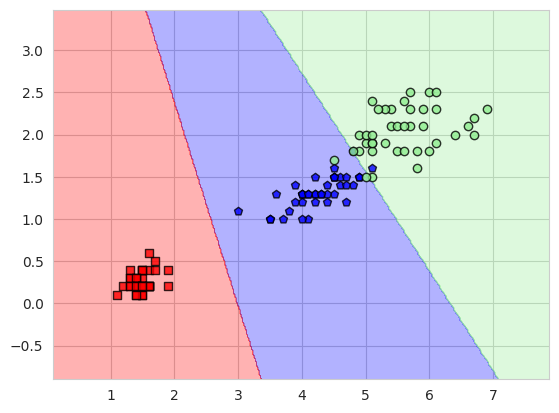

In [18]:
# 최고 성능에 대한 훈련용 데이터의 결정 경계 확인
plot_decision_regions(X=X_train, y=y_train, classifier=best_model)
save_figure('5')

[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


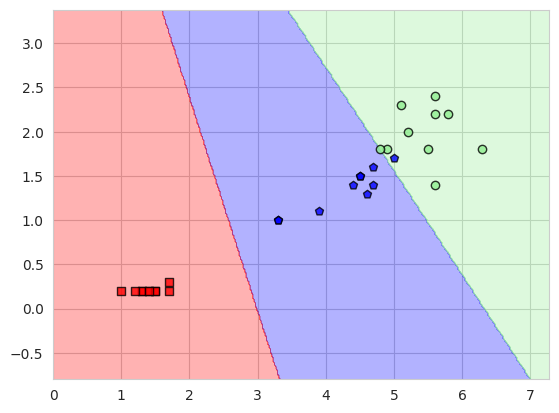

In [19]:
# 최고 성능에 대한 테스트 데이터의 결정 경계 확인
from sklearn.metrics import confusion_matrix
svc_pred = svc_clf.predict(X_test)
print(confusion_matrix(y_test, svc_pred))
plot_decision_regions(X=X_test, y=y_test, classifier=best_model)
save_figure('6')